In [88]:
from bs4 import BeautifulSoup as bs
from bs4 import Tag, NavigableString
import re
import requests as r
import pandas as pd
import numpy as np
import datetime
import csv
import os
import sys
from selenium import webdriver
import censusdata as cd
import geopy
import seaborn as sns

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
df = pd.DataFrame(cd.search('acs1', 2018, 'concept', 'sex by age'))
df[df[0]=='B01001_001E']

0           1                2
279  B01001_001E  SEX BY AGE  Estimate!!Total

In [90]:
blk_males = ['B01001B_003E',
'B01001B_004E',
'B01001B_005E',
'B01001B_006E',
'B01001B_007E',
'B01001B_008E',
'B01001B_009E',
'B01001B_010E',
'B01001B_011E',
'B01001B_012E',
'B01001B_013E',
'B01001B_014E',
'B01001B_015E',
'B01001B_016E']

In [91]:
df = df[(df[1].isin(['SEX BY AGE (SOME OTHER RACE ALONE)',
'SEX BY AGE (ASIAN ALONE)',
'SEX BY AGE (TWO OR MORE RACES)',
'SEX BY AGE (AMERICAN INDIAN AND ALASKA NATIVE ALONE)',
'SEX BY AGE (WHITE ALONE)',
'SEX BY AGE (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)',
'SEX BY AGE (HISPANIC OR LATINO)',
'SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE)']))&(df[0].str.startswith('C'))]

In [92]:
df[2].values

array(['Estimate!!Total', 'Estimate!!Total!!Male',
       'Estimate!!Total!!Male!!Under 18 years',
       'Estimate!!Total!!Male!!18 to 64 years',
       'Estimate!!Total!!Male!!65 years and over',
       'Estimate!!Total!!Female',
       'Estimate!!Total!!Female!!Under 18 years',
       'Estimate!!Total!!Female!!18 to 64 years',
       'Estimate!!Total!!Female!!65 years and over', 'Estimate!!Total',
       'Estimate!!Total!!Male', 'Estimate!!Total!!Male!!Under 18 years',
       'Estimate!!Total!!Male!!18 to 64 years',
       'Estimate!!Total!!Male!!65 years and over',
       'Estimate!!Total!!Female',
       'Estimate!!Total!!Female!!Under 18 years',
       'Estimate!!Total!!Female!!18 to 64 years',
       'Estimate!!Total!!Female!!65 years and over', 'Estimate!!Total',
       'Estimate!!Total!!Male', 'Estimate!!Total!!Male!!Under 18 years',
       'Estimate!!Total!!Male!!18 to 64 years',
       'Estimate!!Total!!Male!!65 years and over',
       'Estimate!!Total!!Female',
       'Esti

In [93]:
cd.geographies(cd.censusgeo([('state','11'),('public use microdata area','*')]),'acs1',2018)

{'District of Columbia (Central) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00105'))),
 'District of Columbia (East) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00104'))),
 'District of Columbia (North) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00102'))),
 'District of Columbia (Northeast) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00103'))),
 'District of Columbia (West) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00101')))}

In [94]:
df.head()

0                         1                                         2
3814  C01001A_001E  SEX BY AGE (WHITE ALONE)                           Estimate!!Total
3815  C01001A_002E  SEX BY AGE (WHITE ALONE)                     Estimate!!Total!!Male
3816  C01001A_003E  SEX BY AGE (WHITE ALONE)     Estimate!!Total!!Male!!Under 18 years
3817  C01001A_004E  SEX BY AGE (WHITE ALONE)     Estimate!!Total!!Male!!18 to 64 years
3818  C01001A_005E  SEX BY AGE (WHITE ALONE)  Estimate!!Total!!Male!!65 years and over

In [95]:
census = cd.download('acs1', 2018,
                            cd.censusgeo([('state','11'),('public use microdata area','*')]),['B01001_001E']+list(df[0].values))
census

B01001_001E  C01001A_001E  C01001A_002E  C01001A_003E  C01001A_004E  C01001A_005E  C01001A_006E  C01001A_007E  C01001A_008E  C01001A_009E  ...  C01001G_009E  C01001I_001E  C01001I_002E  C01001I_003E  C01001I_004E  C01001I_005E  C01001I_006E  C01001I_007E  C01001I_008E C01001I_009E
District of Columbia (West) PUMA, District of C...       112727         88593         42591          7691         27195          7705         46002          7299         29004          9699  ...           398         16048          7468          2576          4608           284          8580          1240          6572          768
District of Columbia (North) PUMA, District of ...       135705         45736         23047          3205         18318          1524         22689          2784         17879          2026  ...           287         30614         15419          5156          9836           427         15195          4194          9848         1153
District of Columbia (Central) PUMA, District o...       160725        101795         52322          2933         46375          3014         49473          2053         43531          3889  ...           149         16350          9526           723          8139           664          6824           911          5205          708
District of Columbia (Northeast) PUMA, District...       126312         54955         28012          5269         20562          2181         26943          4896         20508          1539  ...           190         11724          6426          2339          4087             0          5298          2464          2755           79
District of Columbia (East) PUMA, District of C...       166986          5668          3410           689          2357           364          2258           290          1545           423  ...            73          4513          2301          1116           775           410          2212          1150           919          143

[5 rows x 73 columns]

In [96]:
cols = ['SEX BY AGEEstimate!!Total']+ list(df[1].values + df[2].values)
census.columns = cols
census = census.reset_index()
census['index'] = census['index'].astype(str)
census['puma'] = np.where(census['index'].str.contains('(East)'),1,0)


C:\Users\Noah\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [97]:
census = census[cols+['puma']].groupby(['puma']).sum().reset_index()

In [98]:
def check_save(file_path):
    path = ('data/{}'.format(file_path))
    if os.path.exists(path):
        os.remove(path)
    else:
        print("{} does not exist".format(file_path))
    

def write_out(file_path, url):
    path = ('data/{}'.format(file_path))
    print(file_path)
    with open(path, mode='w', newline='') as file:
        file_writer = csv.writer(file, delimiter=',')
        print(url)
        with r.get(url, verify=False, stream=True) as res:
            lines = (line.decode('utf-8',errors='ignore').replace('\0','') for line in res.iter_lines())
            for row in csv.reader(lines):
                print(row)
                file_writer.writerow(row)

                
                
def create_stuff(file_path,url):
    check_save(file_path)
    write_out(file_path,url)
    
def stack_csvs(my_url):
    with open(path, mode='w', newline='') as file:
        file_writer = csv.writer(file, delimiter=',')
        print(url)
        with r.get(url, verify=False, stream=True) as res:
            lines = (line.decode('utf-8',errors='ignore').replace('\0','') for line in res.iter_lines())
            for row in csv.reader(lines):
                print(row)
                file_writer.writerow(row)

In [99]:
#Downloads the .csv file of all mobility data from the google mobility site
#goog_files = os.getcwd()+'/data'


output = open('traffic_stops.csv', 'wb')
lst = []
        
my_url = ['https://mpdc.dc.gov/node/1429041','https://mpdc.dc.gov/node/1464816']
for url in my_url:
    html = r.get(url)
    soup = bs(html.content,'lxml')
    current_link = ''
    for l in soup.find_all('a'):
        current_link = l.get('href')
        if current_link != None:
            #print(current_link)
            if current_link.find('csv')> 0:
                print(current_link)
                xlsx_file = r.get(current_link)
                lst.extend(xlsx_file)
                
            '''        myfile = r.get(current_link)
                open('{}/{}'.format(goog_files, current_link.rsplit('/', 1)[1].rsplit('.csv',1)[0] + '.csv') ,'wb').write(myfile.content)
                break'''
for x in lst:
    output.write(x)
output.close()


https://mpdc.dc.gov/sites/default/files/dc/sites/mpdc/publication/attachments/Stop%20Data_09092019.csv
https://mpdc.dc.gov/sites/default/files/dc/sites/mpdc/publication/attachments/Stop%20Data_1%20of%203.csv
https://mpdc.dc.gov/sites/default/files/dc/sites/mpdc/publication/attachments/Stop%20Data_2%20of%203.csv
https://mpdc.dc.gov/sites/default/files/dc/sites/mpdc/publication/attachments/Stop%20Data_3%20of%203.csv


In [100]:
df = pd.read_csv('traffic_stops.csv',encoding = "ISO-8859-1")

C:\Users\Noah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,7,11,12,13,14,15,16,17,18,19,20,44,45,46,50) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(74483, 52)
(74481, 52)


In [102]:
df['stop_date'] = pd.to_datetime(df['stop_date'], errors='coerce')

In [103]:
print(df.stop_date.min(), df.stop_date.max())

2019-07-14 00:00:00 2019-12-31 00:00:00


In [105]:
print(df.shape)


(74481, 53)


In [106]:
df['puma'] = np.where((df['stop_district']=='7D')|(df['stop_district']=='6D'),1,0)

In [107]:
df['age'] = np.where(df['age']=='Juvenile','17',df['age'])
df['age'] = pd.to_numeric(df['age'],errors='coerce')

In [110]:
data = df.groupby(['puma','gender','race_ethnicity'])['age'].agg(['mean','count']).reset_index()
data = data[(data['gender']=='Female')|(data['gender']=='Male')]
data_age = df.groupby(['puma','gender','race_ethnicity','age_range'])['age'].agg(['count']).reset_index()
data_age = data_age[((data_age['gender']=='Female')|(data_age['gender']=='Male'))&(data_age['age_range']!='')]

In [113]:
census_mlt = census.melt(id_vars=['puma'])

In [115]:
census_mlt['gender'] = np.where(census_mlt['variable'].str.contains('Male'),'Male','')
census_mlt['gender'] = np.where(census_mlt['variable'].str.contains('Female'),'Female',census_mlt['gender'])


In [116]:
def categorize(dic, column):
    census_mlt[column] = '' 
    for x in dic.keys():
         census_mlt[column] = np.where(census_mlt['variable'].str.contains(x),dic[x],census_mlt[column])
    return census_mlt[column]
    

In [118]:
conditions = {
    '18 to 64 years':'18-64',
    'Under 18 years':'<18',
    '65 years and over':'>64'
    }
census_mlt['metric'] = categorize(conditions,'metric')    

In [119]:
conditions = {
    'SEX BY AGEE':'total',
'(WHITE ALONE)':'White',
'(BLACK OR AFRICAN AMERICAN ALONE)':'Black',
'(ASIAN ALONE)':'Asian',
'(SOME OTHER RACE ALONE)':'Other',
'(TWO OR MORE RACES)':'Multiple',
'(HISPANIC OR LATINO)':'Hispanic',
    }
census_mlt['race_ethnicity'] = categorize(conditions,'race_ethnicity')    

C:\Users\Noah\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [128]:
census_mlt = census_mlt.replace({'':'total'})

In [122]:
census_mlt_race = census_mlt[(census_mlt['gender']=='total')&(census_mlt['metric']=='total')&(census_mlt['race_ethnicity']!='total')].copy()
census_mlt_gen = census_mlt[(census_mlt['gender']!='total')&(census_mlt['metric']=='total')&(census_mlt['race_ethnicity']!='total')].copy()
census_mlt_gen_age = census_mlt[(census_mlt['metric']!='total')].copy()

In [123]:
print(census_mlt.iloc[0:2])
print(census_mlt_race.groupby(['puma'])['value'].sum())
print(census_mlt_gen.groupby(['puma'])['value'].sum())
print(census_mlt_gen_age
      .groupby(['puma'])['value'].sum())

   puma                   variable     value gender metric race_ethnicity
0     0  SEX BY AGEEstimate!!Total  535469.0  total  total          total
1     1  SEX BY AGEEstimate!!Total  166986.0  total  total          total
puma
0    592541.0
1    168431.0
Name: value, dtype: float64
puma
0    592541.0
1    168431.0
Name: value, dtype: float64
puma
0    592541.0
1    168431.0
Name: value, dtype: float64


In [124]:
data.head()

puma  gender race_ethnicity   mean  count
0     0  Female          Asian  39.14    316
1     0  Female          Black  36.12   7838
2     0  Female       Hispanic  35.47    886
3     0  Female       Multiple  38.89     47
4     0  Female          Other  34.62      8

In [125]:
census_mlt_gen['pct'] = np.round((census_mlt_gen['value'] / census_mlt_gen['value'].sum())*100,2)
census_mlt_gen['var'] = 'population'
data['pct'] = np.round((data['count'] / data['count'].sum())*100,2)
data['var'] = 'traffic stops'
grp = pd.concat([data,census_mlt_gen],axis=0)

grp.head()

puma  gender race_ethnicity   mean   count    pct            var variable  value metric
0     0  Female          Asian  39.14   316.0   0.48  traffic stops      NaN    NaN    NaN
1     0  Female          Black  36.12  7838.0  11.82  traffic stops      NaN    NaN    NaN
2     0  Female       Hispanic  35.47   886.0   1.34  traffic stops      NaN    NaN    NaN
3     0  Female       Multiple  38.89    47.0   0.07  traffic stops      NaN    NaN    NaN
4     0  Female          Other  34.62     8.0   0.01  traffic stops      NaN    NaN    NaN

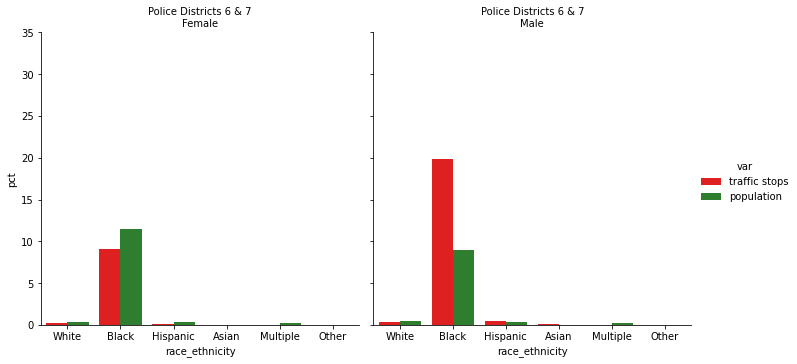

In [126]:
g = sns.catplot(x='race_ethnicity',y='pct',hue='var',col='gender',data=grp[grp['puma']==1],kind='bar',order=['White','Black','Hispanic','Asian','Multiple','Other'],palette=sns.color_palette(['red', 'forestgreen']))
g.set_titles('Police Districts 6 & 7\n{col_name}')
g.set(ylim=(0, 35))

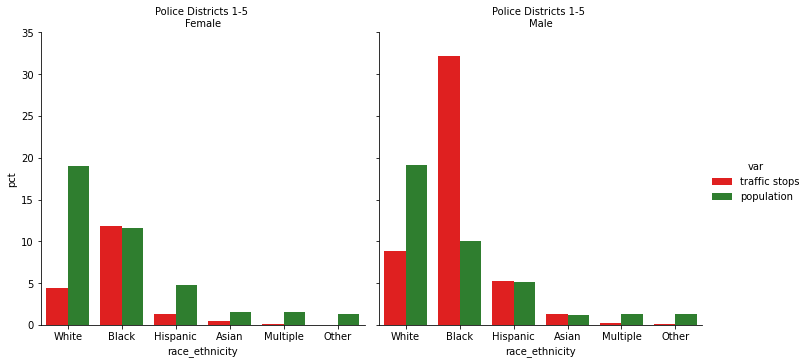

In [127]:
g= sns.catplot(x='race_ethnicity',y='pct',hue='var',col='gender',data=grp[grp['puma']==0],kind='bar',order=['White','Black','Hispanic','Asian','Multiple','Other'],palette=sns.color_palette(['red', 'forestgreen']))
g.set_titles('Police Districts 1-5 \n{col_name}')
g.set(ylim=(0, 35))

# Reasons for Stops

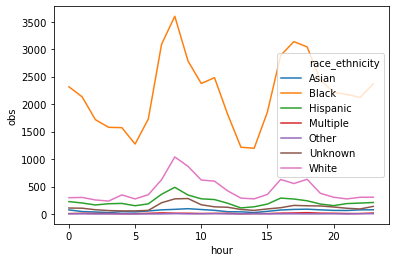

In [41]:
df['obs']= 1
df['hour'] = df['stop_time'].str.extract('(^[0-9]*[^\(:]+)')
df['hour'] = pd.to_numeric(df['hour'],errors='coerce')
sns.lineplot(x='hour',y='obs',hue='race_ethnicity',data=df.groupby(['hour','race_ethnicity'])['obs'].sum().reset_index())

In [72]:
grp_cs = census_mlt_race[['puma','race_ethnicity','value']].copy()
grp_cs.rename(columns={'value':'count'},inplace=True)
grp_cs['value'] = 'census demographics'
grp_cs['pct'] = np.round((grp_cs['count'] / grp_cs['count'].sum())*100,2)

In [73]:
df['stop_reason'] = np.where(df['stop_reason_nonticket'].notnull(),df['stop_reason_nonticket'],df['stop_reason_harbor'])
df['stop_reason'] = np.where(df['stop_reason'].isnull(),df['stop_reason_ticket'],df['stop_reason'])
df_reasons = pd.concat([df,df['stop_reason'].str.split(';',expand=True)],axis=1)
df_reasons = df_reasons[['puma','observation','race_ethnicity','gender','age',0,1,2,3,4,5,6,7]].melt(id_vars=['observation','race_ethnicity','gender','age','puma'])
df_reasons.value = df_reasons.value.str.strip()
df_reasons.head()

observation race_ethnicity gender   age  puma variable                 value
0           1          Black   Male  63.0     1        0     Traffic violation
1           2          Black   Male  17.0     0        0  Individuals actions
2           3          Black   Male  45.0     1        0  Individuals actions
3           4          Black   Male  27.0     0        0      Call for service
4           5          Black   Male  17.0     1        0      Call for service

In [74]:
df_reasons['value'].replace({'Calls for service':'Call for service'},inplace=True)
grp = df_reasons.groupby(['puma','race_ethnicity','value'])['age'].agg(['count','mean']).reset_index()
grp['pct'] = np.round((grp['count'] / df.shape[0])*100,2)
grp['district'] = np.where(grp['puma']==0,'Police Districts 1 - 5',"Police Districts 6 & 7")
grp_cs['district'] = np.where(grp_cs['puma']==0,'Police Districts 1 - 5',"Police Districts 6 & 7")

In [75]:
df_reasons['value'].value_counts()

Observed moving violation                                    35683
Call for service                                             12075
Observed equipment violation                                  5366
Individual<U+0092>s actions                                   4733
Traffic violation                                             4067
BOLO/Lookout                                                  3156
Suspicion of criminal activity (self-initiated)               3081
Warrant/court order                                           2459
Information obtained from law enforcement sources             2426
Response to Crash                                             2075
Information obtained from witnesses or informants             1582
Prior knowledge                                               1301
Individual<U+0092>s characteristics                           1139
Individuals actions                                           778
Demeanor during a field contact                               

In [76]:
col_order = list(df_reasons['value'].value_counts().index)

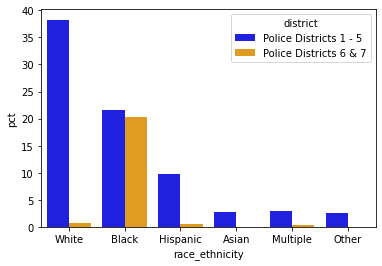

In [77]:
sns.barplot(x='race_ethnicity',y='pct',hue='district',data=grp_cs,palette=sns.color_palette(['blue', 'orange']),ci=None,
           order=['White','Black','Hispanic','Asian','Multiple','Other'])

C:\Users\Noah\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Noah\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


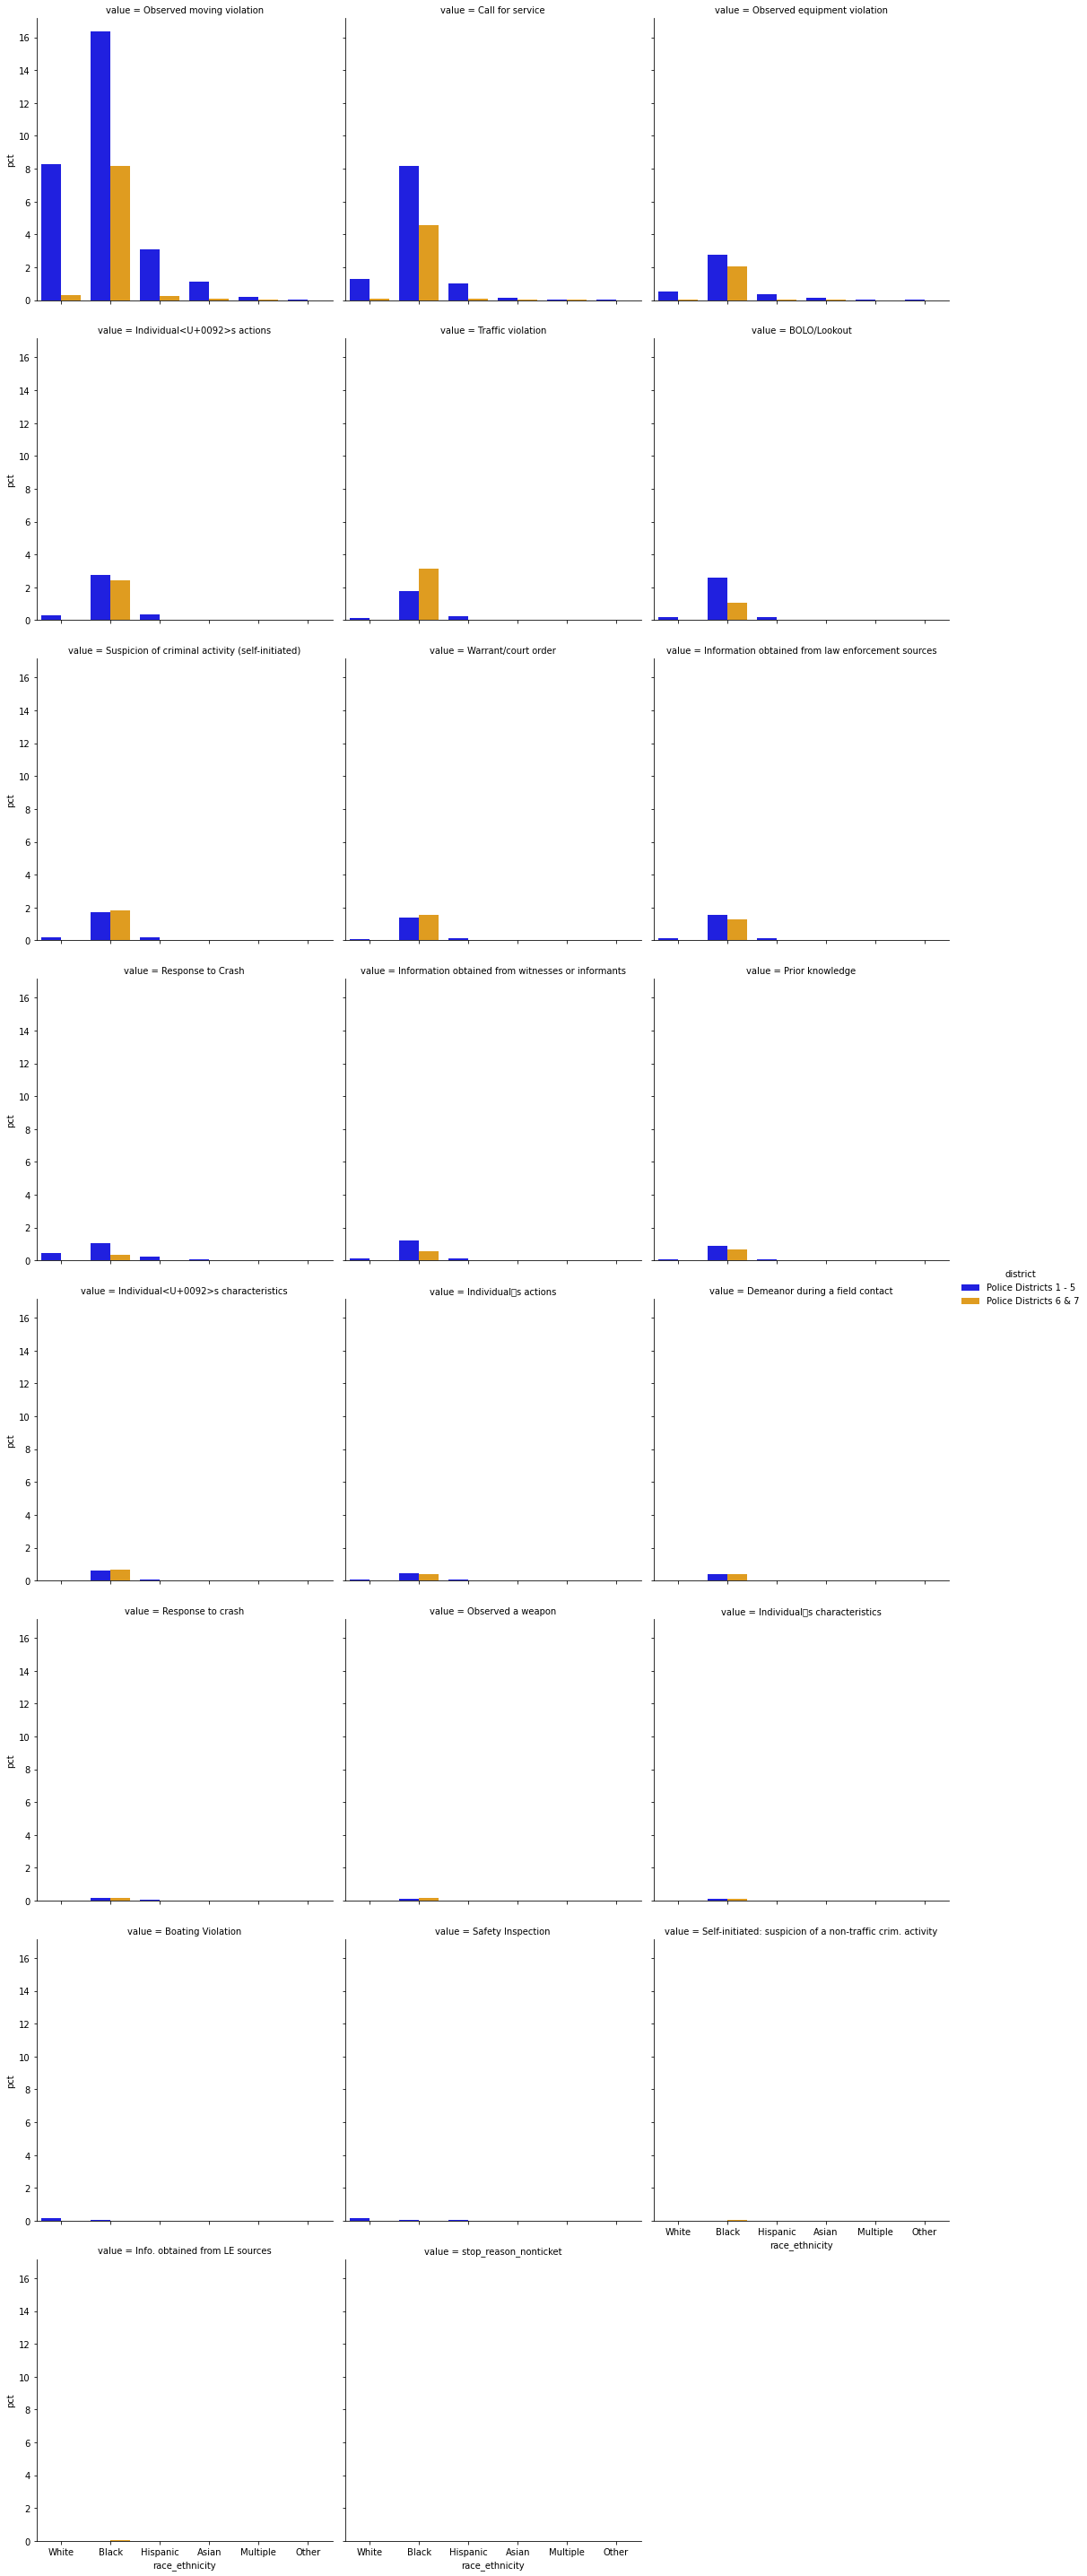

In [78]:
g= sns.catplot(x='race_ethnicity',y='pct',hue='district',col='value',data=grp,kind='bar',col_wrap=3,palette=sns.color_palette(['blue', 'orange']),ci=None,
              order=['White','Black','Hispanic','Asian','Multiple','Other'],col_order=col_order)


# Who's paying for tickets

In [133]:
grp_cs = census_mlt_gen[['puma','race_ethnicity','gender','pct']].copy()
grp_cs['value'] = 'census demographics'
grp_cs['district'] = np.where(grp_cs['puma']==0,'Police Districts 1 - 5',"Police Districts 6 & 7")

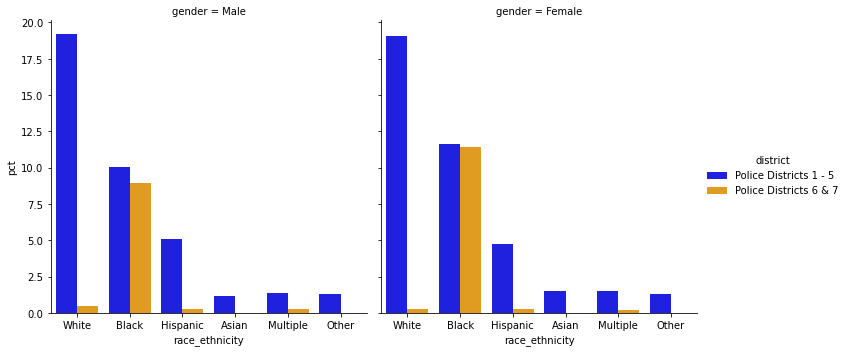

In [151]:
sns.catplot(x='race_ethnicity',y='pct',hue='district',col='gender',kind='bar',data=grp_cs,palette=sns.color_palette(['blue', 'orange']),ci=None,
           order=['White','Black','Hispanic','Asian','Multiple','Other'],col_order=['Male','Female'])

In [146]:
df['ticket'] = np.where(df['stop_reason_nonticket'].notnull(),1,0)
grp = df[df['stop_reason_harbor'].isnull()].groupby(['puma','race_ethnicity','gender'])['ticket'].sum().reset_index()
grp = grp[grp.gender.isin(['Female','Male'])]
grp['pct'] = np.round((grp['ticket'] / grp.ticket.sum())*100,2)
grp['district'] = np.where(grp['puma']==0,'Police Districts 1 - 5',"Police Districts 6 & 7")

AttributeError: 'FacetGrid' object has no attribute 'set_title'

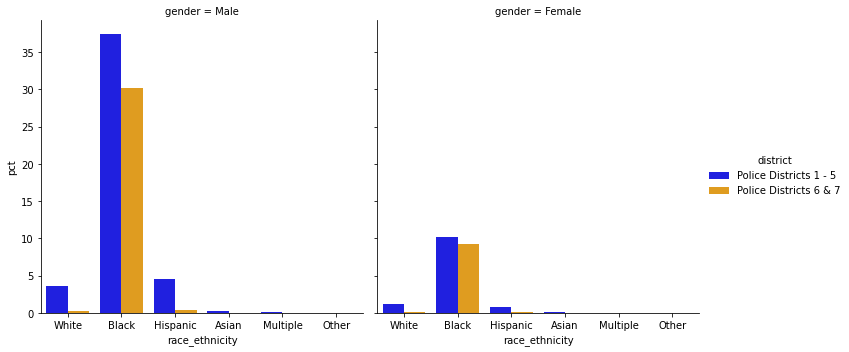

In [154]:
# Share of total tickets
g= sns.catplot(x='race_ethnicity',y='pct',hue='district',col='gender',data=grp,kind='bar',palette=sns.color_palette(['blue', 'orange']),ci=None,
              order=['White','Black','Hispanic','Asian','Multiple','Other'],col_order=['Male','Female'])

In [159]:
df['ticket'] = np.where(df['stop_reason_nonticket'].notnull(),1,0)
grp = df[df['stop_reason_harbor'].isnull()].groupby(['puma','race_ethnicity','gender'])['ticket'].agg(['sum','count']).reset_index()
grp = grp[grp.gender.isin(['Female','Male'])]

grp['pct'] = np.round((grp['sum'] / grp['count'])*100,2)
grp['district'] = np.where(grp['puma']==0,'Police Districts 1 - 5',"Police Districts 6 & 7")

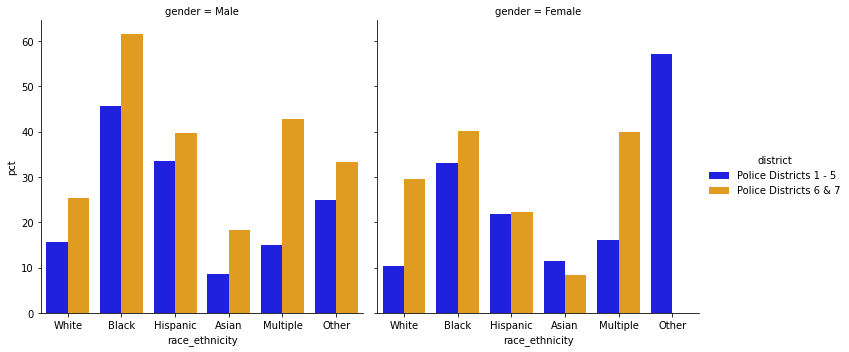

In [160]:
#Share of stops resulting in tickets
g= sns.catplot(x='race_ethnicity',y='pct',hue='district',col='gender',data=grp,kind='bar',palette=sns.color_palette(['blue', 'orange']),ci=None,
              order=['White','Black','Hispanic','Asian','Multiple','Other'],col_order=['Male','Female'])

# Black Males

In [79]:
census = cd.download('acs5', 2018,
                            cd.censusgeo([('state','11'),('public use microdata area','*')]),blk_males)
cols = ['Under 5 years',
'5 to 9 years',
'10 to 14 years',
'15 to 17 years',
'18 and 19 years',
'20 to 24 years',
'25 to 29 years',
'30 to 34 years',
'35 to 44 years',
'45 to 54 years',
'55 to 64 years',
'65 to 74 years',
'75 to 84 years',
'85 years and over']

census.columns = cols
census = census.reset_index()
census['index'] = census['index'].astype(str)
census['puma'] = np.where(census['index'].str.contains('(East)'),1,0)
census =census[['puma']+cols].groupby(['puma']).sum().reset_index()
census_melt = pd.melt(census,id_vars='puma')
census_melt

C:\Users\Noah\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


puma           variable  value
0      0      Under 5 years   4159
1      1      Under 5 years   6715
2      0       5 to 9 years   4418
3      1       5 to 9 years   5509
4      0     10 to 14 years   3685
5      1     10 to 14 years   4824
6      0     15 to 17 years   2442
7      1     15 to 17 years   2778
8      0    18 and 19 years   2209
9      1    18 and 19 years   2078
10     0     20 to 24 years   6358
11     1     20 to 24 years   5161
12     0     25 to 29 years   7330
13     1     25 to 29 years   5188
14     0     30 to 34 years   5973
15     1     30 to 34 years   4515
16     0     35 to 44 years   9816
17     1     35 to 44 years   7441
18     0     45 to 54 years  11377
19     1     45 to 54 years   6917
20     0     55 to 64 years  11012
21     1     55 to 64 years   7688
22     0     65 to 74 years   6499
23     1     65 to 74 years   4150
24     0     75 to 84 years   3239
25     1     75 to 84 years   1531
26     0  85 years and over   1638
27     1  85 years and over    589

In [80]:
conditions = [census_melt['variable'].isin(['Under 5 years',
                                '5 to 9 years',
                                '10 to 14 years',
                                '15 to 17 years']),
        census_melt['variable'] == '18 and 19 years',
        census_melt['variable'] == '20 to 24 years',
        census_melt['variable'] == '25 to 29 years',
        census_melt['variable'] == '30 to 34 years',
      census_melt['variable'] == '35 to 44 years',
    census_melt['variable'] == '45 to 54 years',
            census_melt['variable'].isin(['55 to 64 years',
                                '65 to 74 years',
                                '75 to 84 years',
                                '85 years and over'])
       ]

selections =['Under 18\nyears',
'18 and 19\nyears',
'20 to 24\nyears',
'25 to 29\nyears',
'30 to 34\nyears',
'35 to 44\nyears',
'45 to 54\nyears',
'55 and over']


In [81]:
census_melt['age_bucket'] = np.select(conditions,selections)
census_melt = census_melt.groupby(['puma','age_bucket'])['value'].sum().reset_index()
census_melt

puma        age_bucket  value
0      0  18 and 19\nyears   2209
1      0   20 to 24\nyears   6358
2      0   25 to 29\nyears   7330
3      0   30 to 34\nyears   5973
4      0   35 to 44\nyears   9816
5      0   45 to 54\nyears  11377
6      0       55 and over  22388
7      0   Under 18\nyears  14704
8      1  18 and 19\nyears   2078
9      1   20 to 24\nyears   5161
10     1   25 to 29\nyears   5188
11     1   30 to 34\nyears   4515
12     1   35 to 44\nyears   7441
13     1   45 to 54\nyears   6917
14     1       55 and over  13958
15     1   Under 18\nyears  19826

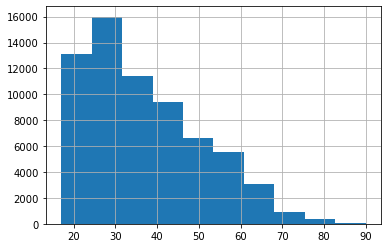

In [82]:
df['age'].hist()

In [83]:
conditions = [df['age']<=17,
(df['age']>=18)&(df['age']<=19),
(df['age']>=20)&(df['age']<=24),
(df['age']>=25)&(df['age']<=29),
(df['age']>=30)&(df['age']<=34),
(df['age']>=35)&(df['age']<=44),
(df['age']>=45)&(df['age']<=54),
(df['age']>=55)]


df['age_bucket'] = np.select(conditions,selections,'missing')
data = df[(df['gender']=='Male')&(df['race_ethnicity']=='Black')&(df['age'].notnull())].groupby(['puma','age_bucket'])['age'].agg(['count']).reset_index()
data

puma        age_bucket  count
0      0  18 and 19\nyears    576
1      0   20 to 24\nyears   2412
2      0   25 to 29\nyears   3669
3      0   30 to 34\nyears   2855
4      0   35 to 44\nyears   4272
5      0   45 to 54\nyears   3092
6      0       55 and over   3214
7      0   Under 18\nyears   1241
8      1  18 and 19\nyears    526
9      1   20 to 24\nyears   2091
10     1   25 to 29\nyears   2716
11     1   30 to 34\nyears   1855
12     1   35 to 44\nyears   2348
13     1   45 to 54\nyears   1488
14     1       55 and over   1437
15     1   Under 18\nyears    698

In [84]:
census_melt['pct'] = np.round((census_melt['value'] / census_melt['value'].sum())*100,2)
census_melt['var'] = 'black male population'
data['pct'] = np.round((data['count'] / data['count'].sum())*100,2)
data['var'] = 'black male traffic stops'
grp = pd.concat([data,census_melt],axis=0)
grp['district'] = np.where(grp['puma']==0,'Police Districts 1 - 5',"Police Districts 6 & 7")

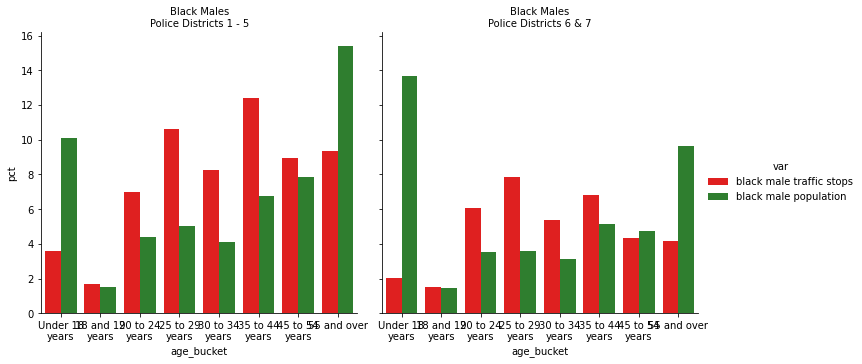

In [85]:
g = sns.catplot(x='age_bucket',y='pct',hue='var',col='district',data=grp,kind='bar',
                palette=sns.color_palette(['red', 'forestgreen']), order=selections)
g.set_titles('Black Males\n{col_name}')

In [86]:
vol = ['Call for service',
'Information obtained from witnesses or informants',
'BOLO/Lookout', 
'Individual<U+0092>s actions',
'Prior knowledge',
'Demeanor during a field contact',
'Individual<U+0092>s characteristics',
'Suspicion of criminal activity (self-initiated)',
'Information obtained from law enforcement sources',

'Calls for service',
'Self-initiated: suspicion of a non-traffic crim. activity',
'Info. obtained from LE sources']


man = ['Warrant/court order',
       'Observed equipment',
'Observed moving violation',
    'Traffic violation',
        'Response to crash',
            'Observed a weapon',
'Safety Inspection',
'Boating Violation',
    'Response to Crash']
df['police'] = np.where((df['stop_reason_nonticket'].isin(man))|(df['stop_reason_harbor'].isin(man))|(df['stop_reason_ticket'].isin(man)),'mandatory','voluntary')

In [127]:
df['police'].value_counts()

voluntary    10616
mandatory    10226
Name: police, dtype: int64

In [ ]:
df